# Supernova Model Fitting
In this notebook, we fit SN models to synthetic supernovae.

In [20]:
%load_ext autoreload
%autoreload 2

from lightkurve import KeplerTargetPixelFile
import numpy as np
import matplotlib.pyplot as plt
import sncosmo
from lightkurve.injection import SupernovaModel

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
tpf = KeplerTargetPixelFile.from_archive(220381074) 

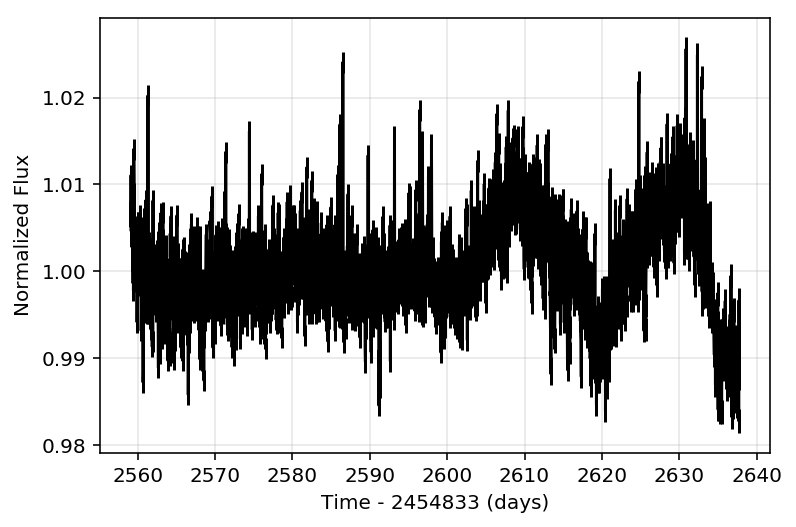

In [22]:
lc = tpf.to_lightcurve(aperture_mask='all') 
lc = lc.remove_nans().remove_outliers() 
x = lc.time
y = lc.flux
y_err = lc.flux_err
lc.plot()

In [23]:
import lightkurve.injection as inj

We are injecting a supernova into this light curve.

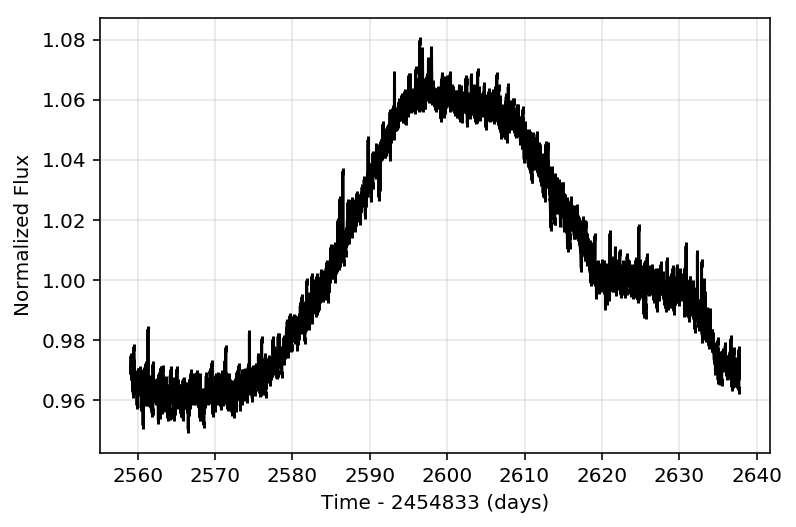

In [33]:
model = inj.SupernovaModel(T0=2600, source='hsiao', bandpass='kepler', z=0.5, amplitude=5e-8)
lcinj = inj.inject(lc, model)
lcinj = lcinj.remove_nans()
lcinj.plot()

Likelihood:  
$p(y\mid\theta)$

Prior:  
$p(\theta)$

Posterior Probability Density Distribution Function (PDF):  
$p(\theta\mid y) \propto p(y\mid\theta) \cdot p(\theta)$

For MCMC sampling, we will directly compute the posterior PDF. For optimization, we will *merely* find the maximum likelihood - in other words, the single value for $\theta$ (eg. $m, b$) that maximizes the likelihood function.  The convention in optimization is to seek the minimum value of the input function.  Accordingly, we must multiply the likelihood function by -1 so that the maximum likelihood corresponds to the minimum.

We want to compute the maximum a posteriori estimation, $\hat\theta_{map}$.


In [34]:
#wavelength = np.array([500., 10000., 19500., 29000., 38500., 48000.])
#transmission = np.array([0., 1., 1., 1., 1., 0.])
#all_band = sncosmo.Bandpass(wavelength, transmission, name='all')

def ln_like(theta):
    T0, z, amplitude, background = theta
    if z < 0 or z > 1 or T0 < np.min(lc.time) or T0 > np.max(lc.time):
        return 1.e99
    model = SupernovaModel(T0, z=z, amplitude=amplitude, bandpass='kepler')
    model = model.evaluate(x) + background
    inv_sigma2 = 1.0/(y_err**2)
    chisq = (np.sum((y-model)**2*inv_sigma2))
    lnlikelihood = -0.5*chisq
    return lnlikelihood


In [35]:
def neg_ln_like(theta):
    return -1 * ln_like(theta)

In [36]:
def lnprior(theta):
    T0, z, amplitude, background = theta
    if z < 0 or z > 1:
        return 0.0
    return -np.inf

Optimization can't handle infinity values, so we redefine a lnprior that returns very large numbers instead of infinity.

In [37]:
def lnprior_optimization(theta):
    T0, z, amplitude, background = theta
    if z < 0 or z > 1:
        return 0.0
    return -1.e99

In [38]:
def ln_posterior(theta):
    lp = lnprior(theta)
    return lp + ln_like(theta)

In [39]:
def neg_ln_posterior(theta):
    log_posterior = lnprior_optimization(theta) + ln_like(theta)
    return -1 * log_posterior

In [41]:
import scipy.optimize as op

#Injected values: T0=2600, z=0.5, amplitude=5e-8

x0 = [2610, 0.5, 3.0e-8, np.percentile(lc.flux, 3)]
xmin = [2500., 0.0, 1.e-8, None]
xmax = [2700., 2.0, 9.e-8, None]

# rewrite the bounds in the way required by L-BFGS-B
bounds = [(low, high) for low, high in zip(xmin, xmax)]

result = op.minimize(neg_ln_posterior, x0)

print(result)

T0_f, z_f, amplitude_f, background_f = result["x"]

      fun: 1e+99
 hess_inv: array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1]])
      jac: array([0., 0., 0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 6
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([2.61000000e+03, 5.00000000e-01, 3.00000000e-08, 7.78978709e+03])


In [60]:
print(result.x)

[2.59e+03 4.00e-01 2.60e-08]


In [61]:
model_fit = inj.SupernovaModel(T0=result.x[0], source='hsiao', bandpass='kepler', z=result.x[1], amplitude=result.x[2])
model_fit = model_fit.evaluate(lc.time)

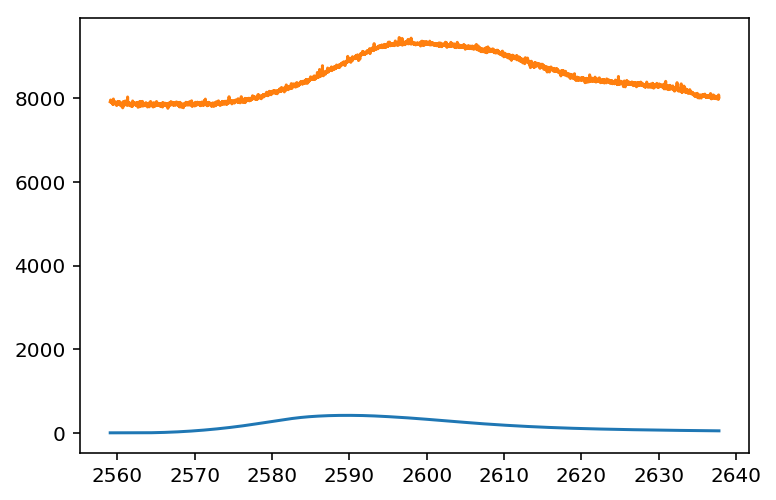

In [62]:
lcinj.normalize()
plt.plot(lc.time, model_fit)
plt.plot(lc.time, lcinj.flux)

In [272]:
ndim, nwalkers = 3, 100
pos = [[2600, 0.5, 2.e-8] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [273]:
import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, threads=4)

emcee: Exception while calling your likelihood function:
  params: [ 2.59889717e+03 -6.39128583e-01 -2.56682532e+00]
  args: []
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/Users/sheilasagear/anaconda2/lib/python2.7/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-270-d1446d9719e9>", line 3, in lnprob
    return lp + neg_ln_like(theta)
  File "<ipython-input-268-f4b31da96a10>", line 8, in neg_ln_like
    model = model.evaluate(x)
  File "/Users/sheilasagear/github/lightkurve/lightkurve/injection.py", line 243, in evaluate
    band_intensity = model.bandflux(self.bandpass, time)  #Units: e/s/cm^2
  File "/Users/sheilasagear/anaconda2/lib/python2.7/site-packages/sncosmo/models.py", line 1339, in bandflux
    raise e
ValueError: bandpass 'kepler' [3640, .., 9190] outside spectral range [360.871, .., 9021.79]


In [274]:
%%time
mcmc_result = sampler.run_mcmc(pos, 2000)

ValueError: bandpass 'kepler' [3640, .., 9190] outside spectral range [360.871, .., 9021.79]

#### 